# Analysis with the AnalysisModule Class

In [5]:
class AnalysisModule:
    """ Module for easy analysis of details.log json file and rgb images """

    def __init__(self, file_location):
        self.file_location = file_location
        self.image_location = file_location + "images/"
        self.df = self._loadDetailsJson(file_location)
        self.varyingVariables = self._outputVaryingVariables()

    def _loadDetailsJson(self, file_location):
        import pandas as pd 
        import numpy as np
        import json
        """ load json detail.log """
        class_map = json.load(open(file_location+'class_maps.json'))
        df = pd.DataFrame.from_records(list(map(json.loads, open(file_location+'details.log').readlines())))
        df = df.drop('render_args', axis=1).join(pd.DataFrame(df.render_args.values.tolist()))
        df['prediction'] = df['prediction'].apply(lambda x: class_map[x[0]])
        df['is_correct'] = (df['is_correct'] == 'True') 
        return df
    
    def _outputVaryingVariables(self):
        """ Get list of dependent variables """
        varying_variables = []
        #ignore columns 0-3 ('is_correct', 'loss', 'prediction', 'id')
        for colname in self.df.columns[4:]:
            if (self.df[colname].dtype == "object"): # if it is not numeric
                if (self.df[colname].nunique() > 1):
                    varying_variables.append(colname)
            else: # if it is numeric
                if (self.df[colname].var() > 0.0001): 
                    varying_variables.append(colname)
        return varying_variables

    def variableSettingAccuracies(self, variable_name):
        """ Accuracy on one variable, across different values """
        if (variable_name in self.varyingVariables):
            return self.df.groupby(variable_name).agg(
                accuracy=('is_correct', 'mean'),
                most_frequent_prediction=('prediction', lambda x: x.mode())).sort_values(['accuracy'],ascending=True)
        else:
            print("Variable name either does not exist in the dataframe or remains constant through the experiment")
            print("Valid Variable Entries: "+ str(self.varyingVariables))
            print("To get overall accuracy use .overallAccuracy()")

    def overallAccuracy(self):
        """ Accuracy across all variables """
        print("Overall Accuracy: "+str(self.df['is_correct'].mean()))

    def varianceOfVariableAccuracies(self):
        """ Which variables affects accuracy the most (changing of settings cause drastic changes in accuracy) """
        import pandas as pd 
        variances = {}
        for i, colname in enumerate(self.varyingVariables):
            variances[colname] = [float(self.df.groupby(colname).agg(accuracy=('is_correct', 'mean')).var())]
        return pd.DataFrame(variances).transpose().rename({0: 'Accuracy Variance'}, axis=1).sort_values(['Accuracy Variance'],ascending=False)

    def lowestAccuracyPerVariable(self):
        import pandas as pd 
        """ Which setting in each variable yield the lowest accuracy? """
        lowestAccuracies = {}
        for i, colname in enumerate(self.varyingVariables):
            variableSettingAccuracies = self.variableSettingAccuracies(colname)
            lowestAccuracies[colname] = [variableSettingAccuracies["accuracy"].idxmin(), 
                                        variableSettingAccuracies["accuracy"].min()]
        return pd.DataFrame(lowestAccuracies).transpose().rename({0: 'lowest_setting', 
                                                                    1:'lowest_accuracy'}, axis=1).sort_index()
    
    def _filterImageIds(self, filter_input):
        """
        Get list of ids of images that pass through the filters

        Filter_input should be in this format (inclusive of edges):

            filter_input = { 
                'HazeControl.haze_fac' : 0,
                'OrbitingCameraControl.theta': (0, 1.57),
                'RainControl.n_layers_of_rain': (0, 3),
                'SunControl.elevation': 0
            }
            
        """
        filtered_df = self.df.copy()
        for key, value in filter_input.items():
            if (type(value) is tuple):
                filtered_df = filtered_df.loc[(filtered_df[key]<=value[1]) & (filtered_df[key]>=value[0])]
            else:
                filtered_df = filtered_df.loc[filtered_df[key]==value]
        return filtered_df['id'].tolist()

    def _getImageLabel(self, image_id, displayed_values):
        """ Get label of an image """
        dictionaryToDisplay = self.df[self.df['id']==image_id][displayed_values].to_dict('records')[0]
        label = ""
        for key, value in dictionaryToDisplay.items():
            label += str(key)+": "+ str(value)+"\n"
        return label
    
    def _getImageCorrect(self, image_id):
        import pandas as pd 
        """ Find out if image was correctly predicted by the model. """
        return self.df[self.df["id"]==image_id]['is_correct'].bool()

    def _getImagePrediction(self, image_id):
        """ Find out if image was correctly predicted by the model. """
        import pandas as pd 
        return self.df[self.df["id"]==image_id]['prediction'].to_string(index=False)

    def getFilteredImages(self, filter_input, columns=4, displayed_values=[]):
        """ Display Filtered Images """
        from math import ceil
        import matplotlib.pyplot as plt
        from matplotlib.image import imread

        if (not (all(elem in self.df.columns for elem in displayed_values))):
            print("Not all columns in display_values are in the dataframe")
            return
        elif (len(displayed_values)==0): #if no values entered for displayed_values
            displayed_values=self.varyingVariables

        # Get number of rows
        image_ids = self._filterImageIds(filter_input)
        num_images = len(image_ids)
        rows = ceil(num_images/columns)

        #if there are no images
        if (len(image_ids)<=0):
            print("There are no images.")
            return

        #if there are images

        #Get figure height
        figure_width = 20
        size_of_each_image = figure_width/columns
        size_of_each_line_in_label = 0.5
        number_of_displayed_values = len(displayed_values)
        size_of_image_label = size_of_each_image + size_of_each_line_in_label*number_of_displayed_values 
        figure_height = rows * size_of_image_label

        #plot images
        plt.figure(figsize=(figure_width, figure_height))
        for i, image_id in enumerate(image_ids):
            image_filename = self.image_location + image_id + "_rgb.png"
            ax = plt.subplot(rows, columns, i + 1)
            plt.title(self._getImageLabel(image_id, displayed_values))
            color = "green" if self._getImageCorrect(image_id) else "red"
            for spine in ax.spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(7)
            ax.text(9, 17, self._getImagePrediction(image_id),
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 4})
            plt.imshow(imread(image_filename))
        plt.show()

    def getVariableLineGraph(self, variable):
        """ Plot line graph between varying variable (eg. intensity of haze) and accuracy"""
        import pandas as pd
        if (variable not in self.df.columns):
            print("This variable cannot be found in the dataframe")
            return
        elif (variable not in self.varyingVariables):
            print("This variable remains constant throughout all images")
            return
        variable_dataframe = self.variableSettingAccuracies(variable).sort_index()
        variable_dataframe.plot.line(y='accuracy')
    
    def getVariableCorrelation(self, variable):
        import pandas as pd
        if (variable not in self.df.columns):
            print("This variable cannot be found in the dataframe")
            return
        elif (variable not in self.varyingVariables):
            print("This variable remains constant throughout all images")
            return
        variable_dataframe = self.variableSettingAccuracies(variable)
        pcc  = variable_dataframe["accuracy"].corr(variable_dataframe.index.to_series())
        print("Pearson's Correlation Coefficient: "+str(pcc))

## 1. Load json file

In [6]:
analysis = AnalysisModule("../results/")

## 2. Detect which variables have varied

In [17]:
analysis.varyingVariables

['OrbitingCameraControl.theta',
 'SunControl.elevation',
 'HazeControl.haze_fac',
 'RainControl.n_layers_of_rain']

## 3. Overall Accuracy

In [25]:
analysis.overallAccuracy()

Overall Accuracy: 0.08641975308641975


## 4. Accuracy of different settings within a variable

In [18]:
analysis.variableSettingAccuracies('OrbitingCameraControl.theta')

,accuracy,most_frequent_prediction
OrbitingCameraControl.theta,,
0.00,0.000000,mosquito net
-1.57,0.111111,mosquito net
1.57,0.148148,"[bucket, pail, dining table, board, mosquito net]"


## 5. Which variable affects accuracy the most

In [19]:
analysis.varianceOfVariableAccuracies()

,Accuracy Variance
HazeControl.haze_fac,0.008688
SunControl.elevation,0.007316
OrbitingCameraControl.theta,0.005944
RainControl.n_layers_of_rain,0.000457


## 6. Which setting for each variable has the lowest accuracy

In [20]:
analysis.lowestAccuracyPerVariable()

,lowest_setting,lowest_accuracy
HazeControl.haze_fac,0.4,0.000000
OrbitingCameraControl.theta,0.0,0.000000
RainControl.n_layers_of_rain,0.0,0.074074
SunControl.elevation,0.0,0.037037


## 7. Filter images with settings

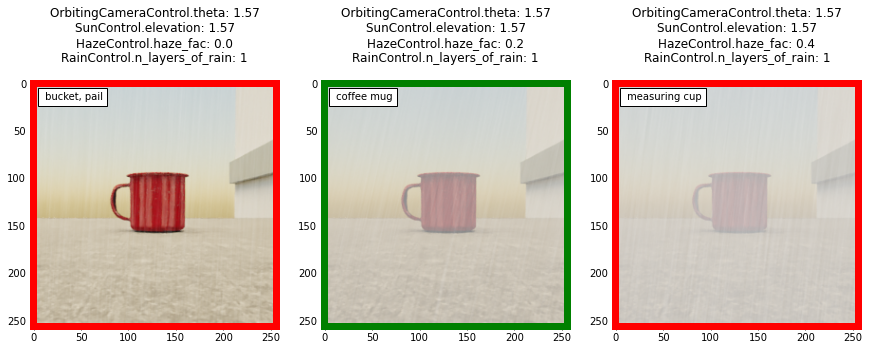

In [7]:
analysis.getFilteredImages(
    filter_input = { #inclusive of edges
        'HazeControl.haze_fac' : (0, 1),
        'OrbitingCameraControl.theta': 1.57,
        'RainControl.n_layers_of_rain': 1,
        'SunControl.elevation': 1.57
    }
)

## 8. Correlation between accuracy and continuous variable
Note: Only applicable for ratio variables

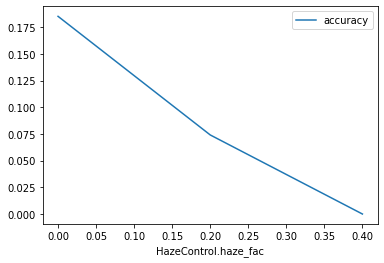

In [51]:
#View line graph to determine if there is a linear relationship between accuracy and variable
analysis.getVariableLineGraph('HazeControl.haze_fac')

In [70]:
analysis.getVariableCorrelation('HazeControl.haze_fac')

Pearson's Correlation Coefficient: -0.9933992677987827
